# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotclusteraverages, plotGridSearch
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Signaling data

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

0/438 peptides were not found in the proteome.
438


In [4]:
X

,Protein,Sequence,UniprotAcc,Position,BioReps,r2_Std,Gene,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",TAEPDyGALYE,P19174,Y771-p,1,N/A,PLCG1,0.146277,-0.452506,-0.212346,-0.322889,0.265081,0.025052,0.304444,0.039775,0.132145,0.074967
1,26S proteasome regulatory subunit 4,DKKKKyEPPVP,P62191,Y25-p,1,N/A,PSMC1,-0.108045,-0.476332,-0.321637,-0.239781,0.126419,0.274226,0.243800,0.210842,0.326859,-0.036352
2,40S ribosomal protein S27,QSPNSyFMDVK,P42677,Y31-p,1,N/A,RPS27,-0.086052,-0.094996,-0.173403,-0.185023,-0.079203,0.107230,-0.124472,0.160896,0.230457,0.244567
3,40S ribosomal protein S3,VRRACyGVLRF,P23396,Y120-p,1,N/A,RPS3,0.056686,0.139572,-0.020027,0.035964,-0.440089,-0.006117,-0.069619,0.003662,0.209473,0.090494
4,40S ribosomal protein SA,LTEASyVNLPT,P08865,Y139-p,1,N/A,RPSA,-0.905683,-0.264555,0.166887,0.990224,-0.256346,0.239761,-0.126352,0.681401,-0.332600,-0.192736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,Tyrosine-protein phosphatase non-receptor type...,PSFSEyASVQV,P78324,Y496-p,1,N/A,SIRPA,0.959928,-0.907931,-0.033116,-0.481825,0.436319,-0.163870,0.024939,0.111514,0.109740,-0.055698
324,Uncharacterized protein C11orf52,HLENAtEYATL,Q96A22,T101-p,1,N/A,C11orf52,0.444559,-0.611138,0.181484,-0.460965,0.458726,-0.214453,-0.020277,-0.018105,0.043728,0.196441
325,Uncharacterized protein C6orf132,PGSADyGFAPA,Q5T0Z8,Y1142-p,1,N/A,C6orf132,0.919313,0.008038,-0.628323,-0.065899,-0.067763,0.441085,-0.160495,-0.329553,-0.004565,-0.111838
326,Uncharacterized protein KIAA1671,RIEPRyDIVHA,Q9BY89,Y733-p,1,N/A,KIAA1671,0.179742,-0.054978,-0.171872,0.065117,0.023957,0.160009,0.114581,-0.237162,0.088879,-0.168274


## Cell Phenotypes

### Cell Viability

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [6]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [7]:
v_ae

,Lines,Treatment,Viability
0,WT,A/E,4.403463
1,KO,A/E,1.661781
2,KD,A/E,2.430256
3,KI,A/E,3.194731
4,Y634F,A/E,3.000097
5,Y643F,A/E,3.051070
6,Y698F,A/E,3.819585
7,Y726F,A/E,3.599395
8,Y750F,A/E,3.680701
9,Y821F,A/E,2.955662


### Cell Death

In [8]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [9]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]

cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [10]:
cd_ae

,Lines,Treatment,Apoptosis
0,WT,A/E,3.691883
1,KO,A/E,7.664414
2,KD,A/E,4.564952
3,KI,A/E,4.377763
4,Y634F,A/E,3.669173
5,Y643F,A/E,5.044015
6,Y698F,A/E,3.803003
7,Y726F,A/E,3.277052
8,Y750F,A/E,3.320825
9,Y821F,A/E,2.643537


### Cell Migration

In [11]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [12]:
ftp = 12
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [13]:
m_ae

,Lines,Treatment,Migration
0,WT,A/E,79.708804
1,KO,A/E,59.678504
2,KD,A/E,59.351836
3,KI,A/E,78.931115
4,Y634F,A/E,77.178136
5,Y643F,A/E,79.026550
6,Y698F,A/E,82.495564
7,Y726F,A/E,78.351154
8,Y750F,A/E,73.529358
9,Y821F,A/E,69.620674


### PCA Analysis

In [14]:
from sklearn.decomposition import PCA

In [15]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"]], axis=1)

In [16]:
y_fc = pd.concat([y_ae.iloc[:, :2], y_ae.iloc[:, 2:] / y_e.iloc[:, 2:]], axis=1)
y_fc["Treatment"] = "A fold-change to E"

In [17]:
y_fc

,Lines,Treatment,Viability,Apoptosis,Migration
0,WT,A fold-change to E,1.503950,0.357265,0.994102
1,KO,A fold-change to E,0.954029,1.124600,0.874078
2,KD,A fold-change to E,1.040835,0.834264,0.970822
3,KI,A fold-change to E,1.103106,0.829127,1.130721
4,Y634F,A fold-change to E,1.109425,0.721999,1.100216
5,Y643F,A fold-change to E,1.197808,0.867798,1.092991
6,Y698F,A fold-change to E,1.281392,0.778741,1.218097
7,Y726F,A fold-change to E,1.247131,0.649464,1.213338
8,Y750F,A fold-change to E,1.208811,0.923612,1.092641
9,Y821F,A fold-change to E,1.077344,0.506015,1.090899


In [18]:
c = 3
pp = PCA(n_components=c)

dScor_ = pp.fit_transform(y_fc.iloc[:, 2:].values)
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, y_fc, c, ["Lines", "Treatment"], "Phenotype")
varExp = np.round(pp.explained_variance_ratio_, 2)

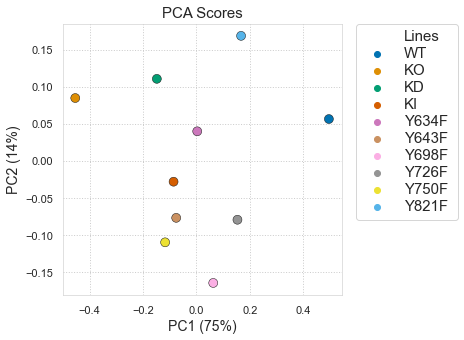

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Lines", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);

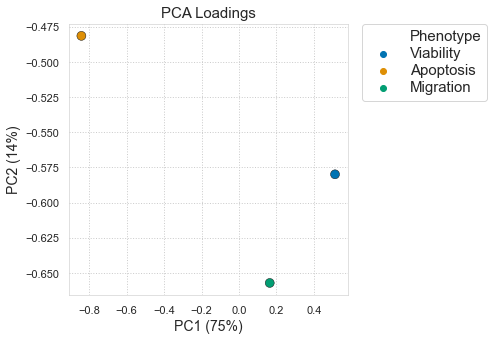

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Phenotype", ax=ax, s=80, markers=["o", "X", "d"], **{'linewidth':.5, 'edgecolor':"k"})
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15)
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [21]:
from scipy.stats import zscore

In [22]:
y = y_ae.drop("Treatment", axis=1).set_index("Lines")
y.iloc[:, :] = zscore(y.iloc[:, :])

# Co-clustering and PLSR model

In [23]:
# pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000)

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [24]:
distance_method = "PAM250"
ncl = 10
GMMweight = 10

MSC = MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method, n_runs=5).fit(d, y)
centers = MSC.transform(d)

start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
53.16224092489641
N_ITER:  1
56.46752798360111
N_ITER:  2
56.76874503047889
N_ITER:  3
56.76874503047889
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
53.469032108692716
N_ITER:  1
59.67295389873718
N_ITER:  2
63.709436044113474
N_ITER:  3
63.25685516355583
N_ITER:  4
63.82964509199734
N_ITER:  5
63.44167540327647
N_ITER:  6
63.406294538689394
N_ITER:  7
63.406294538689394
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
51.45974282800829
N_ITER:  1
54.983730877429934
N_ITER:  2
54.983730877429934
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:

#### R2Y/Q2Y

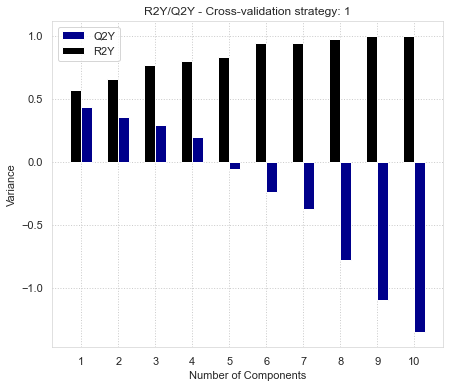

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plsr = PLSRegression(n_components=2)
plotR2YQ2Y(ax, plsr, centers, y, 1, ncl+1)
# fig.savefig("RQ2Y_CV1.png")

#### Predictions

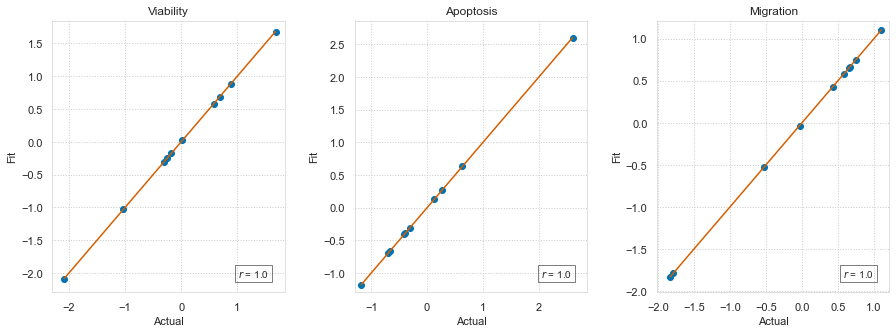

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, plsr, centers, y, 1, y_pred="fit")

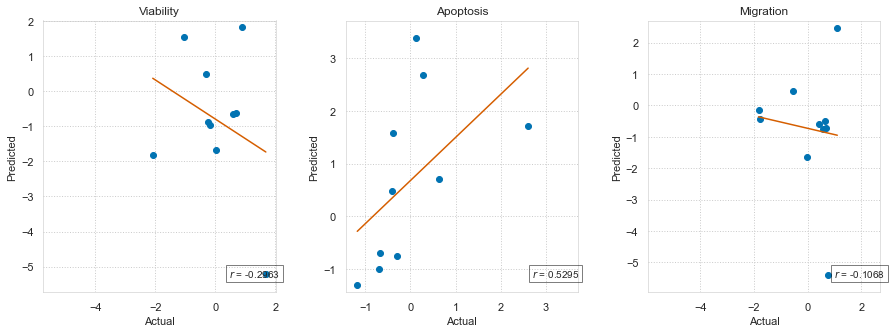

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, plsr, centers, y, 1, y_pred="cross-validation")
# fig.savefig("MeasuredVsPredicted_CV1.png")

#### Scores & Loadings

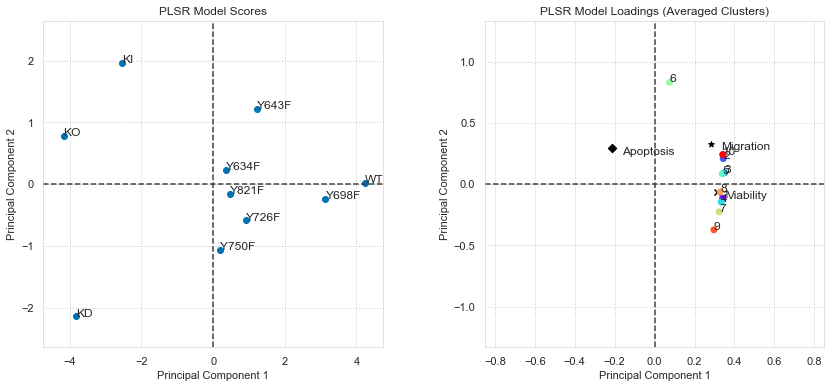

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, plsr.fit(centers, y), centers, y, ncl, all_lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
fig.savefig("ScoresLoadings_CV1.pdf")

In [29]:
cl = MSC.clustermembers(X.T)

In [30]:
create_download_link(cl, "clusters")

#### Cluster Averages

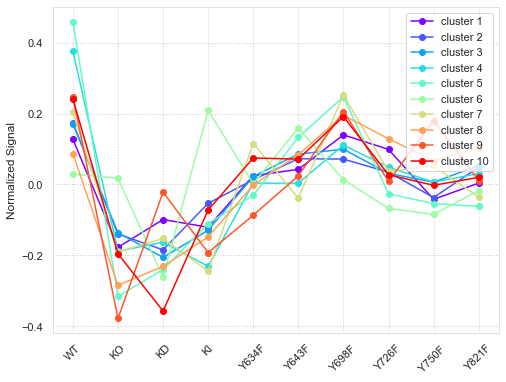

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, MSC.transform(d).T, all_lines)
# fig.savefig("ClusterAverages_CV1.pdf")

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [32]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
53.670587020649315
N_ITER:  1
55.54971189102651
N_ITER:  2
56.83394014890088
N_ITER:  3
56.64253866170286
N_ITER:  4
56.746542522472986
N_ITER:  5
57.06051979182584
N_ITER:  6
57.52945108564004
N_ITER:  7
58.20260290735083
N_ITER:  8
58.56912470457684
N_ITER:  9
58.26232148206424
N_ITER:  10
58.6983542638097
N_ITER:  11
58.91576289695401
N_ITER:  12
58.91576289695401
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
53.27589439357845
N_ITER:  1
56.4337482703549
N_ITER:  2
56.48114576379628
N_ITER:  3
56.48114576379628
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
52.36707986537692
N_ITER:  1
52.93470265849828
N_ITER:  2
55.82941557030973
N_I

#### R2Y/Q2Y

start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
48.93979546857939
N_ITER:  1
53.45535064804959
N_ITER:  2
53.56345892736174
N_ITER:  3
53.958847982339776
N_ITER:  4
54.055683646695016
N_ITER:  5
54.21659355844891
N_ITER:  6
54.244701535815274
N_ITER:  7
54.244701535815274
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
49.55054933966459
N_ITER:  1
53.36476062109405
N_ITER:  2
53.76870440199009
N_ITER:  3
54.51673392704102
N_ITER:  4
54.715736702403085
N_ITER:  5
54.86014353146355
N_ITER:  6
55.03408438573907
N_ITER:  7
55.03408438573907
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
50.90769608329848
N_ITER:  1
55.09126064801167
N_ITER:  2
55.063565674535916
N_ITER:  3
55.063565674535916

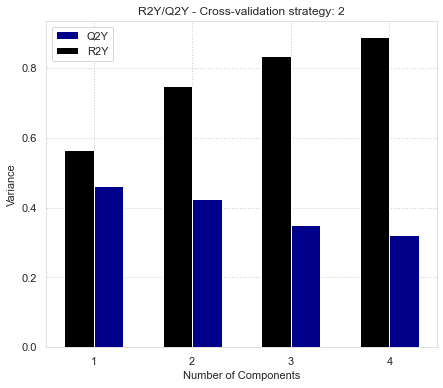

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [34]:
# scores = MSclusPLSR_tuning(d, i, y, "Binomial")

# scores = pd.DataFrame(scores)
# hp = scores.sort_values(by="mean_test_scores", ascending=False)
# hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))
# hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
# hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

Import:

In [35]:
gs = pd.read_csv("msresist/data/Model/20200320-GridSearch_pam250_CVWC_wPC9.csv")

In [36]:
gs[gs["#Components"] == 2].head(10)

,Unnamed: 0,Ranking,#Clusters,#Components,GMMweights,mean_test_scores,mean_train_scores
9,253,10,11,2,5.0,-29.668806,-6.994764
26,377,27,15,2,1.0,-37.047167,-5.660698
30,385,31,15,2,10.0,-37.527371,-3.946341
32,61,33,4,2,5.0,-38.230793,-22.190356
37,165,38,8,2,20.0,-42.491368,-12.261999
40,321,41,13,2,10.0,-43.013695,-6.242054
41,325,42,13,2,20.0,-43.323571,-6.792835
42,189,43,9,2,5.0,-43.595687,-7.462485
44,381,45,15,2,5.0,-43.859577,-5.957370
45,133,46,7,2,20.0,-43.975031,-11.684045


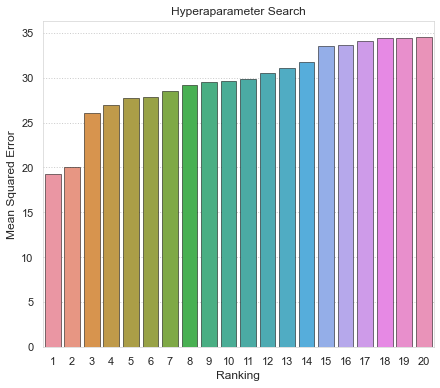

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotGridSearch(ax, gs)

#### Measured vs Predicted

In [38]:
y

,Viability,Apoptosis,Migration
Lines,,,
WT,1.681137,-0.387013,0.750838
KO,-2.085151,2.605363,-1.788918
KD,-1.029486,0.270642,-1.830338
KI,0.020683,0.129638,0.652230
Y634F,-0.246687,-0.404119,0.429960
Y643F,-0.176666,0.631503,0.664331
Y698F,0.879055,-0.303309,1.104187
Y726F,0.576577,-0.699491,0.578693
Y750F,0.688267,-0.666518,-0.032689


start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
52.40548528907694
N_ITER:  1
56.238709713706704
N_ITER:  2
57.967099010953476
N_ITER:  3
60.127319952582845
N_ITER:  4
60.03728532047072
N_ITER:  5
61.24784081540097
N_ITER:  6
62.9035263811133
N_ITER:  7
63.45820318731505
N_ITER:  8
63.67367599319322
N_ITER:  9
63.92566621946031
N_ITER:  10
63.92566621946031
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
51.43577341916253
N_ITER:  1
55.4021004394213
N_ITER:  2
55.600631491282655
N_ITER:  3
55.600631491282655
start initialization...
gmm initialized
calculating pam250 scores...
scores array ready
filling diagonal...
Final scores matrix complete!
N_ITER:  0
47.8886894794516
N_ITER:  1
53.6408234072141
N_ITER:  2
55.211881778285004
N_ITER:  3
55.33549571659651
N_ITER:  4
55.33549571659651
sta

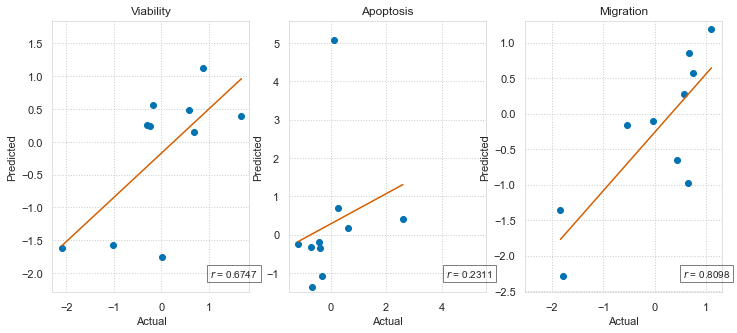

In [39]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

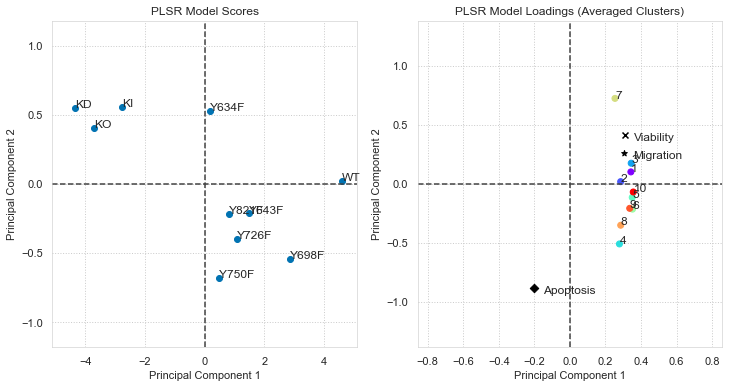

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, all_lines, 2)

In [41]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

#### Cluster Averages

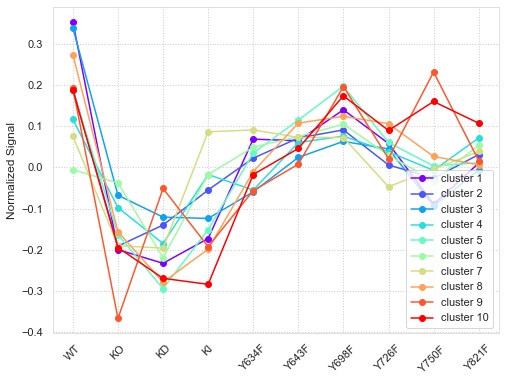

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers.T, all_lines)